# From Posts(=submissions) to Networks

The goal of this tutorial is to break-down a dataframe full of submissions, into a network.
We will then visualize this network.
The overall steps are:
- Load the dataframe.
- Filter on rows that contain interactions (i.e. retweet events).
- Augment the data (i.e. including sentiment).
- Reducing the data frame (if memory is an issue, you can do this first).
- Generating an edgelist, then use it to generate a network object.
- Visualize network

# Install dependencies and import modules

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import nltk

import datetime

In [2]:
nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


# Read dataframe
We will use two files:  
(1) submission_comments_df.csv: contains information on comments  
(2) submission_df.csv: contains information on submissions  

In [4]:
comments_df = pd.read_csv("rdatascience_submission_comments_df.csv", index_col=0)
comments_df.columns

Index(['author', 'body', 'body_html', 'created_utc', 'distinguished', 'edited',
       'id', 'is_submitter', 'link_id', 'parent_id', 'permalink', 'replies',
       'saved', 'score', 'stickied', 'submission', 'subreddit',
       'subreddit_id'],
      dtype='object')

In [5]:
comments_df

,author,body,body_html,created_utc,distinguished,edited,id,is_submitter,link_id,parent_id,permalink,replies,saved,score,stickied,submission,subreddit,subreddit_id
0,realmikeburke,I think it’s just a bad time.,"<div class=""md""><p>I think it’s just a bad tim...",1.692721e+09,NaN,False,jxag8yq,False,t3_15yafe6,t3_15yafe6,/r/datascience/comments/15yafe6/did_i_screw_up...,1,False,180,False,15yafe6,datascience,t5_2sptq
1,Smoky_Mtn_High,I’m on the hunt as well atm but with 3 YOE and...,"<div class=""md""><p>I’m on the hunt as well atm...",1.692723e+09,NaN,False,jxakl5l,False,t3_15yafe6,t3_15yafe6,/r/datascience/comments/15yafe6/did_i_screw_up...,3,False,28,False,15yafe6,datascience,t5_2sptq
2,Fickle_Scientist101,Data engineering is not really a natural progr...,"<div class=""md""><p>Data engineering is not rea...",1.692723e+09,NaN,False,jxakio9,False,t3_15yafe6,t3_15yafe6,/r/datascience/comments/15yafe6/did_i_screw_up...,4,False,79,False,15yafe6,datascience,t5_2sptq
3,kaumaron,If you haven't yet check out r/dataengineering...,"<div class=""md""><p>If you haven&#39;t yet chec...",1.692733e+09,NaN,False,jxbagry,False,t3_15yafe6,t3_15yafe6,/r/datascience/comments/15yafe6/did_i_screw_up...,2,False,12,False,15yafe6,datascience,t5_2sptq
4,Much_Discussion1490,Contractor at FAANg is definitely not somethin...,"<div class=""md""><p>Contractor at FAANg is defi...",1.692722e+09,NaN,False,jxah0l6,False,t3_15yafe6,t3_15yafe6,/r/datascience/comments/15yafe6/did_i_screw_up...,1,False,22,False,15yafe6,datascience,t5_2sptq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1136,Spiritual-Act9545,"In most cases, the company extends these offer...","<div class=""md""><p>In most cases, the company ...",1.692565e+09,NaN,False,jx1np0x,False,t3_15wk84j,t1_jx1hpg5,/r/datascience/comments/15wk84j/how_hard_is_it...,0,False,1,False,15wk84j,datascience,t5_2sptq
1137,Bustin_Cider_,I wanna hear more about the consultant route o...,"<div class=""md""><p>I wanna hear more about the...",1.692585e+09,NaN,False,jx2xwbf,True,t3_15wk84j,t1_jx2xg4z,/r/datascience/comments/15wk84j/how_hard_is_it...,1,False,1,False,15wk84j,datascience,t5_2sptq
1138,Bustin_Cider_,My thought process was if a company is willing...,"<div class=""md""><p>My thought process was if a...",1.692588e+09,NaN,False,jx32tf8,True,t3_15wk84j,t1_jx31kg4,/r/datascience/comments/15wk84j/how_hard_is_it...,1,False,1,False,15wk84j,datascience,t5_2sptq
1139,verus54,Yea sure,"<div class=""md""><p>Yea sure</p>\n</div>",1.692585e+09,NaN,False,jx2yhx7,False,t3_15wk84j,t1_jx2xwbf,/r/datascience/comments/15wk84j/how_hard_is_it...,0,False,1,False,15wk84j,datascience,t5_2sptq


In [6]:
# 'created_utc' column contains Unix timestamp.
# This format tells us how many seconds have past since 1970-01-01 00:00:00
# Quite impressive (and actually practical), but not straightforward for us humans.
# Let's transforme those into YYYY-mm-dd hh:mm:ss format and save them in another column.

comments_df['created_utc_datetime'] = pd.to_datetime(comments_df['created_utc'], unit='s')
comments_df

,author,body,body_html,created_utc,distinguished,edited,id,is_submitter,link_id,parent_id,permalink,replies,saved,score,stickied,submission,subreddit,subreddit_id,created_utc_datetime
0,realmikeburke,I think it’s just a bad time.,"<div class=""md""><p>I think it’s just a bad tim...",1.692721e+09,NaN,False,jxag8yq,False,t3_15yafe6,t3_15yafe6,/r/datascience/comments/15yafe6/did_i_screw_up...,1,False,180,False,15yafe6,datascience,t5_2sptq,2023-08-22 16:23:50
1,Smoky_Mtn_High,I’m on the hunt as well atm but with 3 YOE and...,"<div class=""md""><p>I’m on the hunt as well atm...",1.692723e+09,NaN,False,jxakl5l,False,t3_15yafe6,t3_15yafe6,/r/datascience/comments/15yafe6/did_i_screw_up...,3,False,28,False,15yafe6,datascience,t5_2sptq,2023-08-22 16:50:30
2,Fickle_Scientist101,Data engineering is not really a natural progr...,"<div class=""md""><p>Data engineering is not rea...",1.692723e+09,NaN,False,jxakio9,False,t3_15yafe6,t3_15yafe6,/r/datascience/comments/15yafe6/did_i_screw_up...,4,False,79,False,15yafe6,datascience,t5_2sptq,2023-08-22 16:50:05
3,kaumaron,If you haven't yet check out r/dataengineering...,"<div class=""md""><p>If you haven&#39;t yet chec...",1.692733e+09,NaN,False,jxbagry,False,t3_15yafe6,t3_15yafe6,/r/datascience/comments/15yafe6/did_i_screw_up...,2,False,12,False,15yafe6,datascience,t5_2sptq,2023-08-22 19:29:18
4,Much_Discussion1490,Contractor at FAANg is definitely not somethin...,"<div class=""md""><p>Contractor at FAANg is defi...",1.692722e+09,NaN,False,jxah0l6,False,t3_15yafe6,t3_15yafe6,/r/datascience/comments/15yafe6/did_i_screw_up...,1,False,22,False,15yafe6,datascience,t5_2sptq,2023-08-22 16:28:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1136,Spiritual-Act9545,"In most cases, the company extends these offer...","<div class=""md""><p>In most cases, the company ...",1.692565e+09,NaN,False,jx1np0x,False,t3_15wk84j,t1_jx1hpg5,/r/datascience/comments/15wk84j/how_hard_is_it...,0,False,1,False,15wk84j,datascience,t5_2sptq,2023-08-20 20:53:14
1137,Bustin_Cider_,I wanna hear more about the consultant route o...,"<div class=""md""><p>I wanna hear more about the...",1.692585e+09,NaN,False,jx2xwbf,True,t3_15wk84j,t1_jx2xg4z,/r/datascience/comments/15wk84j/how_hard_is_it...,1,False,1,False,15wk84j,datascience,t5_2sptq,2023-08-21 02:33:19
1138,Bustin_Cider_,My thought process was if a company is willing...,"<div class=""md""><p>My thought process was if a...",1.692588e+09,NaN,False,jx32tf8,True,t3_15wk84j,t1_jx31kg4,/r/datascience/comments/15wk84j/how_hard_is_it...,1,False,1,False,15wk84j,datascience,t5_2sptq,2023-08-21 03:14:21
1139,verus54,Yea sure,"<div class=""md""><p>Yea sure</p>\n</div>",1.692585e+09,NaN,False,jx2yhx7,False,t3_15wk84j,t1_jx2xwbf,/r/datascience/comments/15wk84j/how_hard_is_it...,0,False,1,False,15wk84j,datascience,t5_2sptq,2023-08-21 02:38:09


# Short-hand Pandas Filters


#### First, we filter comments that are under other comments, and are made at a specific date (2023-08-22).  
In this case, 'parent_id' attribute starts with t1.

In [21]:
## | is short-hand for OR ; & is short-hand for AND
comments_to_comments_df = comments_df[(comments_df.parent_id.str.startswith('t1')) & (comments_df.created_utc_datetime >= datetime.datetime(2023, 8, 22))]
comments_to_comments_df

,author,body,body_html,created_utc,distinguished,edited,id,is_submitter,link_id,parent_id,permalink,replies,saved,score,stickied,submission,subreddit,subreddit_id,created_utc_datetime
31,NickSinghTechCareers,"Yup, it’s tough AF out there. Luckily things a...","<div class=""md""><p>Yup, it’s tough AF out ther...",1.692735e+09,NaN,False,jxbghq9,False,t3_15yafe6,t1_jxag8yq,/r/datascience/comments/15yafe6/did_i_screw_up...,0,False,30,False,15yafe6,datascience,t5_2sptq,2023-08-22 20:06:06
32,Old-Astronomer-471,May I know how long and what roles did you app...,"<div class=""md""><p>May I know how long and wha...",1.692724e+09,NaN,False,jxalyh8,True,t3_15yafe6,t1_jxakl5l,/r/datascience/comments/15yafe6/did_i_screw_up...,1,False,5,False,15yafe6,datascience,t5_2sptq,2023-08-22 16:58:49
33,gygodard,How’d you figure out your CV wasn’t passing sc...,"<div class=""md""><p>How’d you figure out your C...",1.692728e+09,NaN,False,jxaxlqi,False,t3_15yafe6,t1_jxakl5l,/r/datascience/comments/15yafe6/did_i_screw_up...,1,False,2,False,15yafe6,datascience,t5_2sptq,2023-08-22 18:10:22
34,valkaress,"> In my case, the issue was not passing the AT...","<div class=""md""><blockquote>\n<p>In my case, t...",1.692758e+09,NaN,1692758654.0,jxd170j,False,t3_15yafe6,t1_jxakl5l,/r/datascience/comments/15yafe6/did_i_screw_up...,0,False,2,False,15yafe6,datascience,t5_2sptq,2023-08-23 02:36:17
35,mac-edmarco,Seconding this. Serious DE work takes actual s...,"<div class=""md""><p>Seconding this. Serious DE ...",1.692725e+09,NaN,False,jxaq1ml,False,t3_15yafe6,t1_jxakio9,/r/datascience/comments/15yafe6/did_i_screw_up...,1,False,31,False,15yafe6,datascience,t5_2sptq,2023-08-22 17:23:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107,orz-_-orz,I don't see a point to train the model on the ...,"<div class=""md""><p>I don&#39;t see a point to ...",1.692729e+09,NaN,False,jxb0405,False,t3_15y9hx9,t1_jxad23j,/r/datascience/comments/15y9hx9/do_you_retrain...,0,False,3,False,15y9hx9,datascience,t5_2sptq,2023-08-22 18:25:46
1108,None,[deleted],"<div class=""md""><p>[deleted]</p>\n</div>",1.692727e+09,NaN,False,jxauxn2,False,t3_15y9hx9,t1_jxad23j,/r/datascience/comments/15y9hx9/do_you_retrain...,0,False,1,False,15y9hx9,datascience,t5_2sptq,2023-08-22 17:53:51
1109,TacoMisadventures,No worries!\n\nI mean the secondary model fitt...,"<div class=""md""><p>No worries!</p>\n\n<p>I mea...",1.692725e+09,NaN,False,jxaop0a,True,t3_15y9hx9,t1_jxao8fy,/r/datascience/comments/15y9hx9/do_you_retrain...,1,False,1,False,15y9hx9,datascience,t5_2sptq,2023-08-22 17:15:42
1110,Trick-Apartment-6873,"Ah got it. So doing this isn't ""wrong"" by any ...","<div class=""md""><p>Ah got it. So doing this is...",1.692726e+09,NaN,False,jxatmo1,False,t3_15y9hx9,t1_jxaop0a,/r/datascience/comments/15y9hx9/do_you_retrain...,0,False,3,False,15y9hx9,datascience,t5_2sptq,2023-08-22 17:45:52


#### Next, we filter comments that are directly below submissions, and are made at a specific date (2023-08-22).
In this case, 'parent_id' attribute starts with t3.

In [25]:
## | is short-hand for OR ; & is short-hand for AND
comments_to_submissions_df = comments_df[(comments_df.is_submitter == False) & (comments_df.parent_id.str.startswith('t3') & (comments_df.created_utc_datetime >= datetime.datetime(2023, 8, 22)))]
comments_to_submissions_df

,author,body,body_html,created_utc,distinguished,edited,id,is_submitter,link_id,parent_id,permalink,replies,saved,score,stickied,submission,subreddit,subreddit_id,created_utc_datetime
0,realmikeburke,I think it’s just a bad time.,"<div class=""md""><p>I think it’s just a bad tim...",1.692721e+09,NaN,False,jxag8yq,False,t3_15yafe6,t3_15yafe6,/r/datascience/comments/15yafe6/did_i_screw_up...,1,False,180,False,15yafe6,datascience,t5_2sptq,2023-08-22 16:23:50
1,Smoky_Mtn_High,I’m on the hunt as well atm but with 3 YOE and...,"<div class=""md""><p>I’m on the hunt as well atm...",1.692723e+09,NaN,False,jxakl5l,False,t3_15yafe6,t3_15yafe6,/r/datascience/comments/15yafe6/did_i_screw_up...,3,False,28,False,15yafe6,datascience,t5_2sptq,2023-08-22 16:50:30
2,Fickle_Scientist101,Data engineering is not really a natural progr...,"<div class=""md""><p>Data engineering is not rea...",1.692723e+09,NaN,False,jxakio9,False,t3_15yafe6,t3_15yafe6,/r/datascience/comments/15yafe6/did_i_screw_up...,4,False,79,False,15yafe6,datascience,t5_2sptq,2023-08-22 16:50:05
3,kaumaron,If you haven't yet check out r/dataengineering...,"<div class=""md""><p>If you haven&#39;t yet chec...",1.692733e+09,NaN,False,jxbagry,False,t3_15yafe6,t3_15yafe6,/r/datascience/comments/15yafe6/did_i_screw_up...,2,False,12,False,15yafe6,datascience,t5_2sptq,2023-08-22 19:29:18
4,Much_Discussion1490,Contractor at FAANg is definitely not somethin...,"<div class=""md""><p>Contractor at FAANg is defi...",1.692722e+09,NaN,False,jxah0l6,False,t3_15yafe6,t3_15yafe6,/r/datascience/comments/15yafe6/did_i_screw_up...,1,False,22,False,15yafe6,datascience,t5_2sptq,2023-08-22 16:28:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1100,Trick-Apartment-6873,Not sure I've ever seen the test set added bac...,"<div class=""md""><p>Not sure I&#39;ve ever seen...",1.692723e+09,NaN,False,jxakj1g,False,t3_15y9hx9,t3_15y9hx9,/r/datascience/comments/15y9hx9/do_you_retrain...,2,False,6,False,15y9hx9,datascience,t5_2sptq,2023-08-22 16:50:08
1101,relevantmeemayhere,You can bootstrap apparent calibration (post h...,"<div class=""md""><p>You can bootstrap apparent ...",1.692733e+09,NaN,1692749981.0,jxbbfrl,False,t3_15y9hx9,t3_15y9hx9,/r/datascience/comments/15y9hx9/do_you_retrain...,0,False,2,False,15y9hx9,datascience,t5_2sptq,2023-08-22 19:35:21
1102,LogisticDepression,Why do you need to retrain your model in the t...,"<div class=""md""><p>Why do you need to retrain ...",1.692720e+09,NaN,False,jxabez6,False,t3_15y9hx9,t3_15y9hx9,/r/datascience/comments/15y9hx9/do_you_retrain...,1,False,3,False,15y9hx9,datascience,t5_2sptq,2023-08-22 15:53:53
1117,Fickle_Scientist101,"I am like you, also not a senior (3 year exp) ...","<div class=""md""><p>I am like you, also not a s...",1.692727e+09,NaN,False,jxav6h3,False,t3_15ya03e,t3_15ya03e,/r/datascience/comments/15ya03e/to_the_sr_mles...,0,False,3,False,15ya03e,datascience,t5_2sptq,2023-08-22 17:55:22


### We want to make edgelists.  
When comments are made below comments, they create a link in this case.  
Thus, 'source' is a comment under 'target' comment.

In [76]:
# This dataframe shows who made 'source' comments, and the 'target' comments' ids

df1 = comments_to_comments_df[['author', 'parent_id', 'body']].copy()
df1['parent_id'] = df1['parent_id'].str.split('_').str[-1]
df1.columns = ['comment_to_comment_author', 'comment_id', 'comment_body']
df1

,comment_to_comment_author,comment_id,comment_body
31,NickSinghTechCareers,jxag8yq,"Yup, it’s tough AF out there. Luckily things a..."
32,Old-Astronomer-471,jxakl5l,May I know how long and what roles did you app...
33,gygodard,jxakl5l,How’d you figure out your CV wasn’t passing sc...
34,valkaress,jxakl5l,"> In my case, the issue was not passing the AT..."
35,mac-edmarco,jxakio9,Seconding this. Serious DE work takes actual s...
...,...,...,...
1107,orz-_-orz,jxad23j,I don't see a point to train the model on the ...
1108,None,jxad23j,[deleted]
1109,TacoMisadventures,jxao8fy,No worries!\n\nI mean the secondary model fitt...
1110,Trick-Apartment-6873,jxaop0a,"Ah got it. So doing this isn't ""wrong"" by any ..."


In [77]:
# This dataframe shows who made 'target' comments, and the 'target' comments' ids

df2 = comments_to_comments_df[['author', 'id']]
df2.columns = ['comment_author', 'comment_id']
df2

,comment_author,comment_id
31,NickSinghTechCareers,jxbghq9
32,Old-Astronomer-471,jxalyh8
33,gygodard,jxaxlqi
34,valkaress,jxd170j
35,mac-edmarco,jxaq1ml
...,...,...
1107,orz-_-orz,jxb0405
1108,None,jxauxn2
1109,TacoMisadventures,jxaop0a
1110,Trick-Apartment-6873,jxatmo1


In [78]:
# merging two dataframe by inner join makes edgelists

df = df1.merge(df2, how='inner', on='comment_id')
comments_network_df = df[['comment_to_comment_author', 'comment_author', 'comment_body']]
comments_network_df.columns = ['source', 'target', 'comment']
comments_network_df

,source,target,comment
0,Smoky_Mtn_High,Old-Astronomer-471,I used jobscanner and did a two week free tria...
1,Smoky_Mtn_High,gygodard,After I’d submit my application I’d often get ...
2,Old-Astronomer-471,mac-edmarco,"Good points, I’m also thinking the same. It’s ..."
3,Fickle_Scientist101,Samurott,"Yeah the labels are finnicky, the Data Enginee..."
4,dukeofgonzo,Samurott,I prefer the title analytics engineer.
...,...,...,...
150,Trick-Apartment-6873,TacoMisadventures,Calibration layer .... Can you tell me more wh...
151,orz-_-orz,TacoMisadventures,I don't see a point to train the model on the ...
152,None,TacoMisadventures,[deleted]
153,TacoMisadventures,Trick-Apartment-6873,No worries!\n\nI mean the secondary model fitt...


In [79]:
df3 = comments_to_submissions_df[['author', 'body', 'link_id']].copy()
df3['link_id'] = df3['link_id'].str.split('_').str[-1]
df3.columns = ['comment_author', 'comment_body', 'submission_id']
df3

,comment_author,comment_body,submission_id
0,realmikeburke,I think it’s just a bad time.,15yafe6
1,Smoky_Mtn_High,I’m on the hunt as well atm but with 3 YOE and...,15yafe6
2,Fickle_Scientist101,Data engineering is not really a natural progr...,15yafe6
3,kaumaron,If you haven't yet check out r/dataengineering...,15yafe6
4,Much_Discussion1490,Contractor at FAANg is definitely not somethin...,15yafe6
...,...,...,...
1100,Trick-Apartment-6873,Not sure I've ever seen the test set added bac...,15y9hx9
1101,relevantmeemayhere,You can bootstrap apparent calibration (post h...,15y9hx9
1102,LogisticDepression,Why do you need to retrain your model in the t...,15y9hx9
1117,Fickle_Scientist101,"I am like you, also not a senior (3 year exp) ...",15ya03e


In [80]:
submission_df = pd.read_csv('/content/rdatascience_submission_df.csv', index_col=0)
submission_df.columns

Index(['author', 'author_flair_text', 'clicked', 'comments', 'created_utc',
       'distinguished', 'edited', 'id', 'is_original_content', 'is_self',
       'locked', 'name', 'num_comments', 'over_18', 'permalink', 'saved',
       'score', 'selftext', 'spoiler', 'stickied', 'subreddit', 'title',
       'upvote_ratio', 'url'],
      dtype='object')

In [81]:
df4 = submission_df[['author', 'id']]
df4.columns = ['submission_author', 'submission_id']
df4

,submission_author,submission_id
0,Bright_Entrance5244,15ymdux
1,emonggyal,15ykwp0
2,Tenet_Bull,15ykm1r
3,reveluv2,15yk8x7
4,Ajinkya1413,15yjk7g
...,...,...
95,save_the_panda_bears,15wjb5j
96,SeriouslySally36,15wikus
97,WarbossPepe,15wh8m2
98,Available-Sea2035,15wg1rk


In [82]:
df = df3.merge(df4, how='inner', on='submission_id')
sub_com_network_df = df[['comment_author', 'submission_author', 'comment_body']]
sub_com_network_df.columns = ['source', 'target', 'comment']
sub_com_network_df

,source,target,comment
0,realmikeburke,Old-Astronomer-471,I think it’s just a bad time.
1,Smoky_Mtn_High,Old-Astronomer-471,I’m on the hunt as well atm but with 3 YOE and...
2,Fickle_Scientist101,Old-Astronomer-471,Data engineering is not really a natural progr...
3,kaumaron,Old-Astronomer-471,If you haven't yet check out r/dataengineering...
4,Much_Discussion1490,Old-Astronomer-471,Contractor at FAANg is definitely not somethin...
...,...,...,...
251,Trick-Apartment-6873,TacoMisadventures,Not sure I've ever seen the test set added bac...
252,relevantmeemayhere,TacoMisadventures,You can bootstrap apparent calibration (post h...
253,LogisticDepression,TacoMisadventures,Why do you need to retrain your model in the t...
254,Fickle_Scientist101,synthphreak,"I am like you, also not a senior (3 year exp) ..."


In [83]:
network_df = pd.concat([sub_com_network_df, comments_network_df], axis=0).reset_index(drop=True)
network_df

,source,target,comment
0,realmikeburke,Old-Astronomer-471,I think it’s just a bad time.
1,Smoky_Mtn_High,Old-Astronomer-471,I’m on the hunt as well atm but with 3 YOE and...
2,Fickle_Scientist101,Old-Astronomer-471,Data engineering is not really a natural progr...
3,kaumaron,Old-Astronomer-471,If you haven't yet check out r/dataengineering...
4,Much_Discussion1490,Old-Astronomer-471,Contractor at FAANg is definitely not somethin...
...,...,...,...
406,Trick-Apartment-6873,TacoMisadventures,Calibration layer .... Can you tell me more wh...
407,orz-_-orz,TacoMisadventures,I don't see a point to train the model on the ...
408,None,TacoMisadventures,[deleted]
409,TacoMisadventures,Trick-Apartment-6873,No worries!\n\nI mean the secondary model fitt...


In [44]:
sent_analyzer = SentimentIntensityAnalyzer()

In [45]:
print(network_df.comment.iloc[0])

I think it’s just a bad time.


In [46]:
sent_analyzer.polarity_scores(network_df.comment.iloc[0])

{'neg': 0.467, 'neu': 0.533, 'pos': 0.0, 'compound': -0.5423}

In [84]:
%%time
network_df["vaderSent"] = network_df.comment.apply(lambda x: sent_analyzer.polarity_scores(x)["compound"])

CPU times: user 282 ms, sys: 0 ns, total: 282 ms
Wall time: 300 ms


In [85]:
network_df

,source,target,comment,vaderSent
0,realmikeburke,Old-Astronomer-471,I think it’s just a bad time.,-0.5423
1,Smoky_Mtn_High,Old-Astronomer-471,I’m on the hunt as well atm but with 3 YOE and...,0.2500
2,Fickle_Scientist101,Old-Astronomer-471,Data engineering is not really a natural progr...,-0.1095
3,kaumaron,Old-Astronomer-471,If you haven't yet check out r/dataengineering...,0.8591
4,Much_Discussion1490,Old-Astronomer-471,Contractor at FAANg is definitely not somethin...,0.6640
...,...,...,...,...
406,Trick-Apartment-6873,TacoMisadventures,Calibration layer .... Can you tell me more wh...,0.3818
407,orz-_-orz,TacoMisadventures,I don't see a point to train the model on the ...,-0.0516
408,None,TacoMisadventures,[deleted],0.0000
409,TacoMisadventures,Trick-Apartment-6873,No worries!\n\nI mean the secondary model fitt...,0.3595


In [49]:
network_df.to_pickle("edgelist.pkl")

### Now that you have an edge list, the goal is to process it and explore it as a network

In [50]:
EL =  pd.read_pickle("edgelist.pkl")

In [51]:
EL

,source,target,comment,vaderSent
0,realmikeburke,Old-Astronomer-471,I think it’s just a bad time.,-0.5423
1,Smoky_Mtn_High,Old-Astronomer-471,I’m on the hunt as well atm but with 3 YOE and...,0.2500
2,Fickle_Scientist101,Old-Astronomer-471,Data engineering is not really a natural progr...,-0.1095
3,kaumaron,Old-Astronomer-471,If you haven't yet check out r/dataengineering...,0.8591
4,Much_Discussion1490,Old-Astronomer-471,Contractor at FAANg is definitely not somethin...,0.6640
...,...,...,...,...
406,Trick-Apartment-6873,TacoMisadventures,Calibration layer .... Can you tell me more wh...,0.3818
407,orz-_-orz,TacoMisadventures,I don't see a point to train the model on the ...,-0.0516
408,None,TacoMisadventures,[deleted],0.0000
409,TacoMisadventures,Trick-Apartment-6873,No worries!\n\nI mean the secondary model fitt...,0.3595


In [86]:
G = nx.Graph() # Creates a graph object
G.add_edges_from( EL[["source","target"]].values ) # Adds edges (and hence nodes from the edgelist)

CC_nodes = list( nx.connected_components(G) )[0] # Generates a list of connected components, extracts the largest
GG = nx.subgraph(G, CC_nodes) # Creates the subgraph of the largest CC

In [87]:
EL[["source","target"]].values

array([['realmikeburke', 'Old-Astronomer-471'],
       ['Smoky_Mtn_High', 'Old-Astronomer-471'],
       ['Fickle_Scientist101', 'Old-Astronomer-471'],
       ['kaumaron', 'Old-Astronomer-471'],
       ['Much_Discussion1490', 'Old-Astronomer-471'],
       ['Cpt_keaSar', 'Old-Astronomer-471'],
       ['mantus_toboggan', 'Old-Astronomer-471'],
       ['TheRoseMerlot', 'Old-Astronomer-471'],
       ['magikarpa1', 'Old-Astronomer-471'],
       ['semicausal', 'Old-Astronomer-471'],
       ['slickfingers', 'Old-Astronomer-471'],
       ['iemg88', 'Old-Astronomer-471'],
       ['No_Doughnut_5057', 'Old-Astronomer-471'],
       ['MrEloi', 'Old-Astronomer-471'],
       ['vazz', 'Old-Astronomer-471'],
       ['NewEcho2940', 'Old-Astronomer-471'],
       ['dfphd', 'Old-Astronomer-471'],
       ['turnbugu', 'Old-Astronomer-471'],
       ['mes4849', 'Old-Astronomer-471'],
       ['killzedvibe', 'Old-Astronomer-471'],
       ['jj_HeRo', 'Old-Astronomer-471'],
       ['Amazing_Requirement', 'Old-Astro

## Original Visaulization |  Networkx

In [92]:
%%time
pos = nx.spring_layout(GG)

CPU times: user 225 ms, sys: 0 ns, total: 225 ms
Wall time: 390 ms


Text(0.5, 1.0, 'This is very ugly')

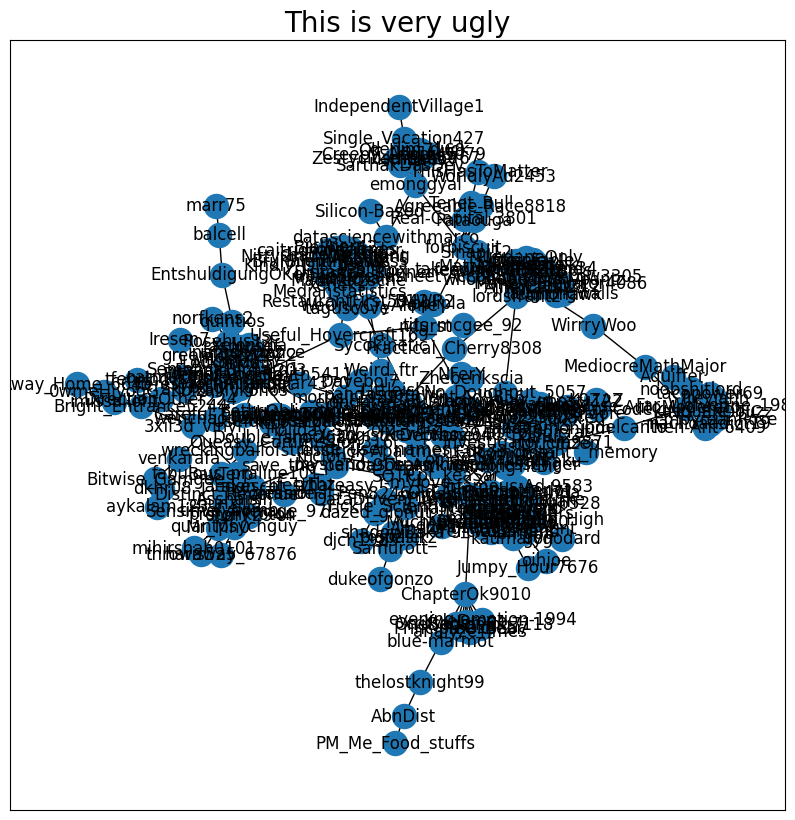

In [93]:
plt.figure(figsize=(10,10))
nx.draw_networkx(GG, pos)
plt.title("This is very ugly", fontsize= 20)

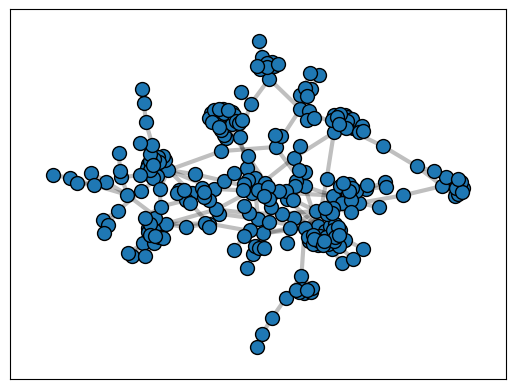

In [94]:
nx.draw_networkx_edges(GG, pos, alpha=0.25, width=3)
nx.draw_networkx_nodes(GG, pos, node_size=100).set_edgecolor('black')